In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import warnings


In [2]:
warnings.filterwarnings("ignore")


In [3]:
# Load the dataset
df = pd.read_csv("data.csv", parse_dates=["invoice_date"], index_col="invoice_date")

In [4]:
# Step 1: Aggregate data monthly
monthly_sales = df['total_sales'].resample('M').sum()

In [5]:
# Step 2: Check for stationarity
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value}")
    if result[1] > 0.05:
        print("Data is non-stationary. Differencing is needed.")
    else:
        print("Data is stationary.")

check_stationarity(monthly_sales)

ADF Statistic: -0.5484287655389811
p-value: 0.8822145168303654
Critical Values:
	1%: -3.7112123008648155
	5%: -2.981246804733728
	10%: -2.6300945562130176
Data is non-stationary. Differencing is needed.


In [6]:
# Step 3: Apply differencing if needed
monthly_sales_diff = monthly_sales.diff().dropna()


In [7]:
# Recheck stationarity after differencing
check_stationarity(monthly_sales_diff)


ADF Statistic: -2.415893717186046
p-value: 0.1373006808314226
Critical Values:
	1%: -3.7238633119999998
	5%: -2.98648896
	10%: -2.6328004
Data is non-stationary. Differencing is needed.


In [8]:
# Step 4: Train ARIMA model
model = ARIMA(monthly_sales, order=(1, 1, 1))  # Adjust (p, d, q) based on your data
arima_model = model.fit()


In [9]:
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:            total_sales   No. Observations:                   27
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -379.924
Date:                Thu, 21 Nov 2024   AIC                            765.848
Time:                        21:48:03   BIC                            769.622
Sample:                    01-31-2021   HQIC                           766.935
                         - 03-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8027      0.914     -0.878      0.380      -2.595       0.989
ma.L1          0.7153      1.043      0.686      0.493      -1.328       2.759
sigma2      3.218e+11   3.06e-11   1.05e+22      0.0

In [10]:
# Step 5: Forecast future sales
forecast_steps = 12  # Forecast for 12 months
forecast = arima_model.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=monthly_sales.index[-1], periods=forecast_steps + 1, freq='M')[1:]

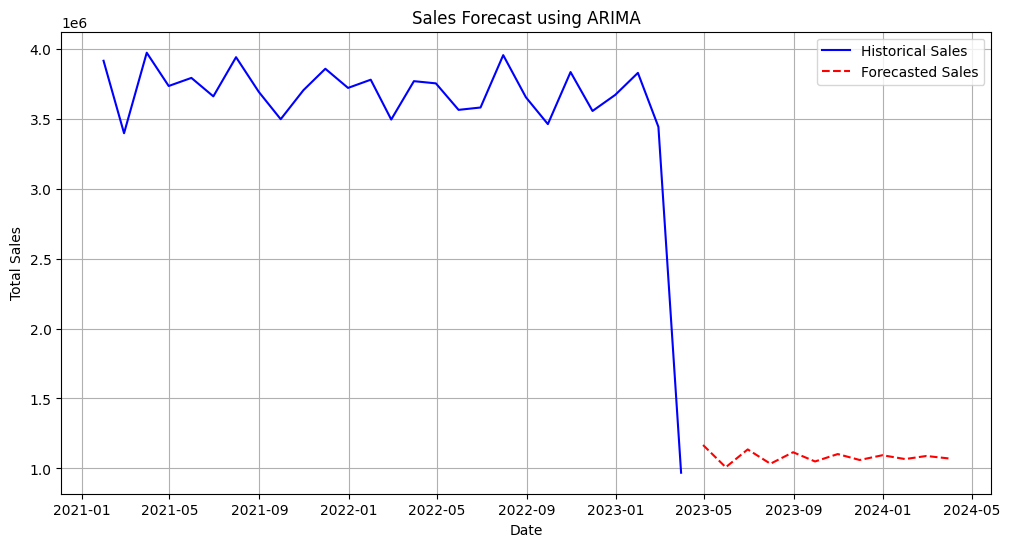

In [11]:
# Step 6: Plot the results
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Historical Sales', color='blue')
plt.plot(forecast_index, forecast, label='Forecasted Sales', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Sales Forecast using ARIMA')
plt.legend()
plt.grid()
plt.show()